In [11]:
from tqdm.notebook import tqdm_notebook

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble, IBMQ
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
from qiskit.tools.monitor import job_monitor

import json
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

ACC_COUNT = 10
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

#IBMQ.save_account("07916ec631273d08971f67f1267677801b440be43215767571a165abe0ac621415a17cc5a357e2e2fffa511a6fd3748eb0c46d35ca79d8752b97788fd71f390a", overwrite=True)
#IBMQ.load_account()

# Circuito

In [2]:
n_qubits = 4

#encoding = RawFeatureVector(16)

#2 Fica num platue de cost = 2
ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")


In [3]:
def get_encode(file):
    """
     Funcao responsavel pelo encoding (amplitude)
        Input :: 
        ### file : File dir
        Output :: 
        #### data_enc : Valores para o encode (numpy array)
    """
    return np.genfromtxt(file, delimiter=";")

def get_mat(predict, labels):
    ret = np.zeros((2,2))
    #predict = model.predict(data_points)
    for p, r in zip(predict, labels):
        if np.array_equal(p,r) and r[0] == 1:
            ret[0,0] += 1
        elif not np.array_equal(p,r) and r[0] == 1:
            ret[1,0] += 1
        elif np.array_equal(p,r) and r[0] == 0:
            ret[1,1]+=1
        elif not np.array_equal(p,r) and r[0] == 0:
            ret[0,1] += 1
    return ret, len(labels)

def get_stats(mat):
    """
    - Recall, True Positive Rate ou Sensitividade - TPR
        Mede uma proporção dos valores que são de facto 
        positivos e que foram preditos corretamente.
        
    - Precision
        Mede a proporção de predições positivas que estão corretas,
        ou seja, quão bem o modelo predisse os valores positivos.
        
    - False Positive Rate - FPR 
        Indica quanto da classe negativa foi 
        predito incorretamente.
    """
    
    stats ={}
    st = ["TPR", "TNR", "Precision", "FPR", "FNR"]
    stats[st[0]] = mat[0,0]/(mat[0,0]*mat[1,0])
    stats[st[1]] = mat[1,1]/(mat[1,1]*mat[0,1])
    stats[st[2]] = mat[0,0]/(mat[0,0]*mat[0,1])
    stats[st[3]] = mat[0,1]/(mat[0,1]*mat[1,1])
    stats[st[4]] = mat[1,1]/(mat[1,1]*mat[0,0])
    return stats

In [4]:
train_data = get_encode(DIR_val_train)
train_labels = get_encode(DIR_cls_train)

test_data = get_encode(DIR_val_test)
test_labels = get_encode(DIR_cls_test)

In [5]:
def circuit_parameters(ansatz, thetas):
    parameters = {}
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None, maxiter=200):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)
                t.update(1)
        # Set up the optimization
        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=maxiter, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations
    
def func_accuracy(data, labels, thetas, self_encoding=False):
    
    circuits = []
    for x in data:
        qc = QuantumCircuit(n_qubits)
        qc.initialize(x)
        qc = qc.compose(ansatz)
        qc = qc.assign_parameters(circuit_parameters(ansatz, thetas))
        qc.measure_all()
        circuits += [qc] 
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()
    
    prediction = [classification(results.get_counts(c)) for c in circuits]
    
    #print(labels)
    #print(prediction)
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [7]:
def cost_function(ansatz, X, Y, thetas, self_encoding=False):

    circuits = []
    for x in X:
        qc = QuantumCircuit(n_qubits)
        qc.initialize(x)
        qc = qc.compose(ansatz)
        qc = qc.assign_parameters(circuit_parameters(ansatz, thetas))
        qc.measure_all()
        circuits += [qc]
    #circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result() #Noise
    

    predictions = [classification(results.get_counts(c)) for c in circuits]
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    #print(f"Cost {cost}")
    
    return cost

In [8]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        exp_val += ((-1)**(count_ones(state)%2))*prob

    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    return (y-y_hat)*(y-y_hat)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

0.8


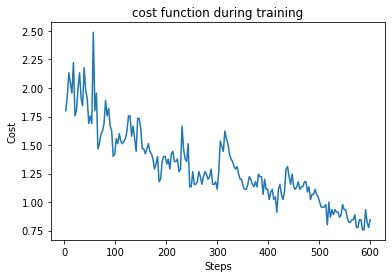

0.7592592592592593


  0%|          | 0/400 [00:00<?, ?it/s]

0.8388888888888889


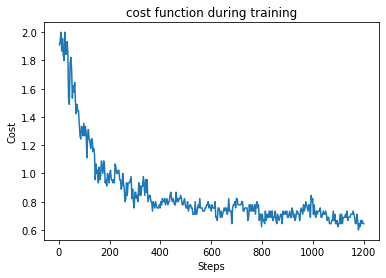

0.7222222222222222


  0%|          | 0/600 [00:00<?, ?it/s]

0.8444444444444444


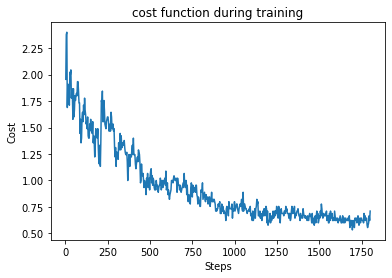

0.6851851851851852


  0%|          | 0/800 [00:00<?, ?it/s]

0.8777777777777778


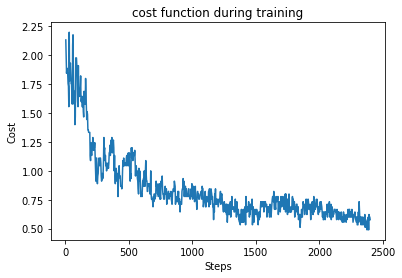

0.7777777777777778


  0%|          | 0/1000 [00:00<?, ?it/s]

0.8833333333333333


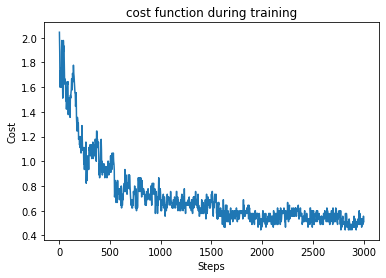

0.7962962962962963


NameError: name 'json' is not defined

In [10]:
maxiter=200
p = tqdm_notebook(total=5)
dic_amp_se = {}
while maxiter <= 1000:
 
    dic_amp_se[maxiter] = {}
    
    dic_amp_se[maxiter]["score"] = {}

    t = tqdm_notebook(total=maxiter)
    opt_var1, opt_value1 , parameters, costs, evaluations = train(ansatz,
                                                                  train_data,
                                                                  train_labels,
                                                                  self_encoding=True, 
                                                                  initial_point=None,
                                                                  maxiter=maxiter)
    
    score_train, prediction_tst = func_accuracy(train_data, train_labels, opt_var1, self_encoding=True)
    dic_amp_se[maxiter]["score"]["trainning"] = score_train
    print(score_train)
    
    fig = plt.figure()
    plt.plot(evaluations, costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.title("cost function during training")
    plt.show()
    
    score_tst, prediction_tst = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
    dic_amp_se[maxiter]["score"]["test"] = score_tst
    print(score_tst)
    
    encoder = OneHotEncoder()
    test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()
    prediction_oh = encoder.fit_transform(np.array(prediction_tst).reshape(-1, 1)).toarray()
    
    mat, lng = get_mat(prediction_oh, test_labels_oh)
    dic_amp_se[maxiter]["mat"] = mat.tolist()
    
    stats = get_stats(mat)
    dic_amp_se[maxiter]["stats"] = stats
    
    dic_amp_se[maxiter]["parameters"] = opt_value1.tolist()
    
    maxiter += 200
    t.update(1)
    
with open('amp_se_4Qbits_tst.json', 'w', encoding ='utf8') as json_file:
    json.dump(dic_amp_se, json_file, ensure_ascii = True)

In [13]:
epochs = [200, 400, 600, 800, 1000]
trainning_scores_amp_se = []

test_scores_amp_se = []
test_TNR_amp_se = []
test_TPR_amp_se = []

for epoch in epochs:
    trainning_scores_amp_se += [dic_amp_se[epoch]["score"]["trainning"]]
                         
    test_scores_amp_se += [dic_amp_se[epoch]["score"]["test"]]
    test_TNR_amp_se += [dic_amp_se[epoch]["stats"]["TNR"]]
    test_TPR_amp_se += [dic_amp_se[epoch]["stats"]["TPR"]]

In [14]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    
    circuits = []
    for x in data:
        qc = QuantumCircuit(n_qubits)
        qc.initialize(x)
        qc = qc.compose(ansatz)
        qc = qc.assign_parameters(circuit_parameters(ansatz, thetas))
        qc.measure_all()
        circuits += [qc] 
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()
    
    prediction = [classification(results.get_counts(c)) for c in circuits]
    
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

acc = []
for _ in range(ACC_COUNT):
    accuracy, prediction = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
    print("Test set accuracy - {}".format(accuracy))
    acc += [accuracy]
print("Test set accuracy (mean) - {}".format(sum(acc)/ACC_COUNT))    

## Cross Entropy Loss

### Parity method

In [15]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [16]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    return probs

def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    return np.sum(y*np.log(y_hat))

In [17]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = []
    for x in data:
        qc = QuantumCircuit(n_qubits)
        qc.initialize(x)
        qc = qc.compose(ansatz)
        qc = qc.assign_parameters(circuit_parameters(ansatz, thetas))
        qc.measure_all()
        circuits += [qc] 

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

def cost_function(ansatz, X, Y, thetas, self_encoding=False):
    circuits = []
    for x in X:
        qc = QuantumCircuit(n_qubits)
        qc.initialize(x)
        qc = qc.compose(ansatz)
        qc = qc.assign_parameters(circuit_parameters(ansatz, thetas))
        qc.measure_all()
        circuits += [qc] 
    

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    #print(f"Cost: {cost}")
    
    return cost

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[-1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1. -1.
 -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.
 -1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1.
  1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1.]
[1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1

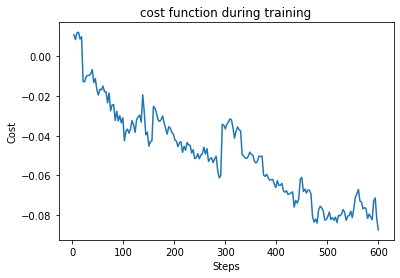

[-1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.
  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.]
[1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1]
0.4444444444444444


  0%|          | 0/400 [00:00<?, ?it/s]

QiskitError: 'Keyboard interrupt in parallel_map.'

In [21]:
maxiter=200
p = tqdm_notebook(total=5)
dic_amp_ce = {}
while maxiter <= 1000:
 
    dic_amp_ce[maxiter] = {}
    
    dic_amp_ce[maxiter]["score"] = {}

    t = tqdm_notebook(total=maxiter)
    opt_var1, opt_value1 , parameters, costs, evaluations = train(ansatz,
                                                                  train_data,
                                                                  train_labels,
                                                                  self_encoding=True, 
                                                                  initial_point=None,
                                                                  maxiter=maxiter)
    
    score_train, prediction_tst = func_accuracy(train_data, train_labels, opt_var1, self_encoding=True)
    dic_amp_ce[maxiter]["score"]["trainning"] = score_train
    print(score_train)
    
    fig = plt.figure()
    plt.plot(evaluations, costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.title("cost function during training")
    plt.show()
    
    score_tst, prediction_tst = func_accuracy(test_data, test_labels, opt_var1, self_encoding=True)
    dic_amp_ce[maxiter]["score"]["test"] = score_tst
    print(score_tst)
    
    
    encoder = OneHotEncoder()
    prediction_oh = encoder.fit_transform(np.array(prediction_tst).reshape(-1, 1)).toarray()
    
    mat, lng = get_mat(prediction_oh, test_labels_oh)
    dic_amp_ce[maxiter]["mat"] = mat.tolist()
    
    stats = get_stats(mat)
    dic_amp_ce[maxiter]["stats"] = stats
    
    dic_amp_ce[maxiter]["parameters"] = opt_value1.tolist()
    
    maxiter += 200
    t.update(1)
    
with open('amp_ce_4Qbits_tst.json', 'w', encoding ='utf8') as json_file:
    json.dump(dic_amp_ce, json_file, ensure_ascii = True)

In [ ]:
epochs = [200, 400, 600, 800, 1000]
trainning_scores_amp_ce = []

test_scores_amp_ce = []
test_TNR_amp_ce = []
test_TPR_amp_ce = []

for epoch in epochs:
    trainning_scores_amp_ce += [dic_amp_ce[epoch]["score"]["trainning"]]
                         
    test_scores_amp_ce += [dic_amp_ce[epoch]["score"]["test"]]
    test_TNR_amp_ce += [dic_amp_ce[epoch]["stats"]["TNR"]]
    test_TPR_amp_ce += [dic_amp_ce[epoch]["stats"]["TPR"]]

acc = []
for _ in range(ACC_COUNT):
    accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
    print("Test set accuracy - {}".format(accuracy))
    acc += [accuracy]
print("Test set accuracy (mean) - {}".format(sum(acc)/ACC_COUNT))

In [ ]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

In [ ]:
print(len(train_data))